# VQE exercise
Erel Dekel - 326064888 \
Dolev Shmariho - \
Due to 03.07.2024

**Installations**

In [45]:
#!pip uninstall qiskit qiskit-aer qiskit-algorithms qiskit_utils
%pip install qiskit
%pip install numpy
%pip install qiskit-aer
%pip install qiskit-algorithms
%pip install matplotlib
%pip install qiskit_ibm_runtime



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
    --------------------------------------- 0.0/2.9 MB 2.0 MB/s eta 0:00:02
   - -------------------------------------- 0.1/2.9 MB 1.1 MB/s eta 0:00:03
   -- ------------------------------------- 0.2/2.9 MB 1.5 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.9 MB 2.4 MB/s eta 0:00:02
   ---------- ----------------------------- 0.8/2.9 MB 3.8 MB/s eta 0:00:01
   --------------- ------------------------ 1.2/2.9 MB 4.6 MB/s eta 0:00:01
   --------------------------- ------------ 2.0/2.9 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------  2.9/2.9 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use

**Imports and code constants**


In [50]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
import matplotlib.image as mpimg

from qiskit_algorithms import VQE
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import Estimator
from qiskit_aer import Aer, QasmSimulator
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import circuit_drawer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info.operators import Operator
from qiskit_ibm_runtime.fake_provider import FakeLimaV2


**Constract H2 Hamiltonian**

In [47]:
g_0 = -0.4804
paulis = ["ZI", "IZ", "ZZ", "YY", "XX"]
coeffs = [0.3435, -0.4347, 0.5716, 0.0910, 0.0910]

H2 = g_0*Operator(qi.SparsePauliOp("II")) \
    +coeffs[0]*Operator(qi.SparsePauliOp(paulis[0])) \
    + coeffs[1]*Operator(qi.SparsePauliOp(paulis[1])) \
    + coeffs[2]*Operator(qi.SparsePauliOp(paulis[2])) \
    + coeffs[3]*Operator(qi.SparsePauliOp(paulis[3])) \
    + coeffs[4]*Operator(qi.SparsePauliOp(paulis[4]))
H2

Operator([[ 1.11022302e-16+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j, -2.73800000e-01+0.j,  1.82000000e-01+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j,  1.82000000e-01+0.j, -1.83020000e+00+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
            1.82400000e-01+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


**Part 1: find the exact solution**

In [48]:
# Find min eigenvalue
eigen_values = np.linalg.eigvalsh(H2)
min_eigenvalue = min(eigen_values)

print("Exact result: " + str(min_eigenvalue))

nuclear_repulsion = 0.7055696146
hydrogen_atom_min_eigenvalue = min_eigenvalue + nuclear_repulsion

Exact result: -1.851199124123644


**Part 2: VQE using ideal simulation**

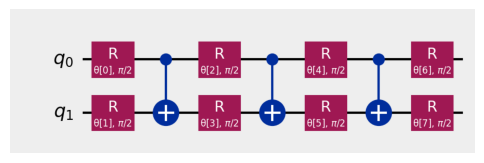

VQE Ground State Energy: -1.851199111958307
Error: 1.2165336960023865e-08


In [79]:
def ansatz_2local(reps = 1, show = False):
    ansatz = TwoLocal(num_qubits=2, rotation_blocks='ry', entanglement_blocks='cx', reps=reps)

    if show:
        full_circuit = ansatz.decompose().decompose()
        circuit_drawer(full_circuit, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='ansatz_circuit.png')
        img = mpimg.imread('ansatz_circuit.png')
        plt.figure(figsize=(6, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    return ansatz

ansatz = ansatz_2local(reps = 3, show = True)
optimizer = COBYLA(maxiter=200)
estimator = Estimator(options={"shots": 10**4})

vqe = VQE(ansatz=ansatz, optimizer=optimizer, estimator=estimator)

result = vqe.compute_minimum_eigenvalue(operator=SparsePauliOp.from_operator(H2))
vqe_ideal_ground_state_energy = result.eigenvalue.real
print(f"VQE Ground State Energy: {vqe_ideal_ground_state_energy}")
print(f"Error: {vqe_ideal_ground_state_energy - min_eigenvalue}")

**Part 2: VQE using noisy simulation**

In [76]:
ansatz = ansatz_2local(reps = 3)
optimizer = COBYLA(maxiter=200)

device_backend = FakeLimaV2()
noise_model = NoiseModel.from_backend(device_backend)

noisy_simulator = AerSimulator(noise_model=noise_model)
estimator = Estimator(options={"shots": 10**4, "backend": noisy_simulator})

vqe = VQE(ansatz=ansatz, optimizer=optimizer, estimator=estimator)

result = vqe.compute_minimum_eigenvalue(operator=SparsePauliOp.from_operator(H2))
vqe_noisy_ground_state_energy = result.eigenvalue.real
print(f"VQE Ground State Energy: {vqe_noisy_ground_state_energy}")
print(f"Error: {vqe_noisy_ground_state_energy - min_eigenvalue}")

VQE Ground State Energy: -1.8511991202529205
Error: 3.870723519483477e-09
